# Exploring CAN SLIM Investing Method on Historical Stock Data
The CAN SLIM Investing method is a method of investing made popular through the book 'How to Make Money on Stocks'. 

The seven parts of the acronym are as follows:

**C** stands for Current quarterly earnings. Per share, current earnings should be up at least 25% in the most recent financial quarter, compared to the same quarter the previous year. Additionally, if earnings are accelerating in recent quarters, this is a positive prognostic sign.<br>

**A** stands for Annual earnings growth, which should be up 25% or more over the last three years. Annual returns on equity should be 17% or more

**N** stands for New product or service, which refers to the idea that a company should have continuing development and innovation. This is what allows the stock to emerge from a proper chart pattern and achieve a new price. A notable example of this is Apple's iPhone.

**S** stands for Supply and demand. A gauge of a stock's demand can be seen in the trading volume of the stock, particularly during price increases.

**L** stands for Leader or laggard? O'Neil suggests buying "the leading stock in a leading industry." This somewhat qualitative measurement can be more objectively measured by the Relative Price Strength Rating of the stock, designed to measure the price performance of a stock over the past 12 months in comparison to the rest of the market based on the S&P 500 (or the S&P/TSX Composite Index for Canadian stock listings) over a set period of time.

**I** stands for Institutional sponsorship, which refers to the ownership of the stock by mutual funds, banks and other large institutions, particularly in recent quarters. A quantitative measure here is the Accumulation/Distribution Rating, which is a gauge of institutional activity in a particular stock.

**M** stands for Market Direction, which is categorized into three - Market in Confirmed Uptrend, Market Uptrend Under Pressure, and Market in Correction. The S&P 500 and NASDAQ are studied to determine the market direction. During the time of investment, O'Neil prefers investing during times of definite uptrends of these indexes, as three out of four stocks tend to follow the general market direction.

In [124]:
import pandas as pd
import numpy as np
import bs4
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
%matplotlib inline
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 800)

# 1 Collecting Stock Data
To get the stock data I chose to run a quick scraper that parsed the website stockpup.com and grabed the CSV files from the page stockpup.com/data/

In [125]:
url = 'http://www.stockpup.com/data/'
html = requests.get(url)
soup = bs4.BeautifulSoup(html.text, "html.parser")

In [126]:
#Create an Empty Dictionary to hold our CSV links
links = {}
#Loop over all <a href> tags on stockpup.com/data.
for link in soup.find_all('a', href=True):
    #If the link contains a .csv file. It will set the key of the links dictionary to the stock ticker and then the value to the url for the csv data.
    if '.csv' in str(link):
        links[re.match("(.*?)(?=_)",str(link)).group().split('/')[2]] = ('http://www.stockpup.com' + link.get('href'))

In [127]:
''' Commenting out below for speed of kernel run

#Next we will loop over each csv in our links dictionary
for link in links.items():
    #read each spreadsheet into a dataframe called data.
    data = pd.read_csv(link[1])
    #Create a symbol feature in the dataframe
    data['symbol'] = link[0]
    #concat the data dataframe into overall dataframe stocks
    stocks = pd.concat([stocks,data])

#drop the null values from the data.
stocks.dropna(inplace=True)
#Read the data to a csv.
stocks.to_csv('stocks.csv')
'''

" Commenting out below for speed of kernel run\n\n#Next we will loop over each csv in our links dictionary\nfor link in links.items():\n    #read each spreadsheet into a dataframe called data.\n    data = pd.read_csv(link[1])\n    #Create a symbol feature in the dataframe\n    data['symbol'] = link[0]\n    #concat the data dataframe into overall dataframe stocks\n    stocks = pd.concat([stocks,data])\n\n#drop the null values from the data.\nstocks.dropna(inplace=True)\n#Read the data to a csv.\nstocks.to_csv('stocks.csv')\n"

In [128]:
#We have data saved so we can quickly load the Dataframe now from a csv without having to run our 
stocks = pd.read_csv('stocks.csv')
#Drop Unnamed Column
stocks.drop('Unnamed: 0', axis=1,inplace=True)

#From exploring below found that there are a lot of str values for 'None'. Replacing these with np.nan
stocks = stocks.replace('None', np.nan)

# 2 Exploring Stock Data

## Quick Data Preview

In [129]:
stocks.head(5)

,Asset turnover,Assets,Book value of equity per share,Capital expenditures,Cash at end of period,Cash change during period,Cash from financing activities,Cash from investing activities,Cash from operating activities,Cumulative dividends per share,Current Assets,Current Liabilities,Current ratio,Dividend payout ratio,Dividend per share,EPS basic,EPS diluted,Earnings,Earnings available for common stockholders,Equity to assets ratio,Free cash flow per share,Goodwill & intangibles,Liabilities,Long-term debt,Long-term debt to equity ratio,Net margin,Non-controlling interest,P/B ratio,P/E ratio,Preferred equity,Price,Price high,Price low,Quarter end,ROA,ROE,Revenue,Shareholders equity,Shares,Shares split adjusted,Split factor,symbol
0,0.55,8698000000,14.02,60000000,2887000000,209000000,37000000,-67000000,215000000,20.62,4397000000,1361000000,3.2307,0.8925,0.149,-0.99,-0.99,-320000000,-320000000,0.5199,0.48,2974000000,4172000000,1800000000,0.3981,0.0425,4000000,4.7,33.48,0,70.3,75.0,65.6,2018-01-31,0.0235,0.0428,1211000000,4522000000,322476579,322476579,1.0,A
1,0.55,8426000000,14.96,58000000,2678000000,115000000,-106000000,-60000000,288000000,20.47,4169000000,1263000000,3.3009,0.2477,0.130,0.54,0.54,177000000,177000000,0.5733,0.71,2968000000,3591000000,1801000000,0.3728,0.153,4000000,4.43,32.83,0,63.37,68.52,58.22,2017-10-31,0.084,0.1511,1189000000,4831000000,323018027,323018027,1.0,A
2,0.55,8261000000,14.32,43000000,2563000000,174000000,29000000,-101000000,228000000,20.34,3996000000,1241000000,3.22,0.2581,0.132,0.55,0.54,175000000,175000000,0.5578,0.57,2987000000,3650000000,1801000000,0.3908,0.1436,3000000,4.31,33.11,0,58.6,61.84,55.36,2017-07-31,0.079,0.1441,1114000000,4608000000,321828003,321828003,1.0,A
3,0.55,8016000000,13.61,43000000,2389000000,148000000,-67000000,-43000000,257000000,20.21,3800000000,1187000000,3.2013,0.2718,0.132,0.51,0.5,164000000,164000000,0.5454,0.67,2941000000,3641000000,1802000000,0.4122,0.1341,3000000,3.92,33.7,0,52.23,55.99,48.47,2017-04-30,0.0738,0.1345,1102000000,4372000000,321337443,321337443,1.0,A
4,0.55,7872000000,13.33,32000000,2241000000,-48000000,-58000000,-101000000,116000000,20.08,3635000000,1089000000,3.3379,0.3011,0.132,0.52,0.52,168000000,168000000,0.5459,0.26,2974000000,3572000000,1802000000,0.4194,0.1195,3000000,3.5,33,0,46.2,49.48,42.92,2017-01-31,0.0653,0.119,1067000000,4297000000,322300905,322300905,1.0,A


In [130]:
stocks.shape

(58743, 42)

### Fundamentals in Dataset

In [131]:
stocks.columns

Index(['Asset turnover', 'Assets', 'Book value of equity per share',
       'Capital expenditures', 'Cash at end of period',
       'Cash change during period', 'Cash from financing activities',
       'Cash from investing activities', 'Cash from operating activities',
       'Cumulative dividends per share', 'Current Assets',
       'Current Liabilities', 'Current ratio', 'Dividend payout ratio',
       'Dividend per share', 'EPS basic', 'EPS diluted', 'Earnings',
       'Earnings available for common stockholders', 'Equity to assets ratio',
       'Free cash flow per share', 'Goodwill & intangibles', 'Liabilities',
       'Long-term debt', 'Long-term debt to equity ratio', 'Net margin',
       'Non-controlling interest', 'P/B ratio', 'P/E ratio',
       'Preferred equity', 'Price', 'Price high', 'Price low', 'Quarter end',
       'ROA', 'ROE', 'Revenue', 'Shareholders equity', 'Shares',
       'Shares split adjusted', 'Split factor', 'symbol'],
      dtype='object')

### Amount of Companies

In [132]:
len(stocks.symbol.unique())

756

### Types of Companies in Dataset

## Converting DataTypes

### Columns DataType

In [133]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58743 entries, 0 to 58742
Data columns (total 42 columns):
Asset turnover                                54908 non-null object
Assets                                        58716 non-null object
Book value of equity per share                58716 non-null object
Capital expenditures                          58743 non-null int64
Cash at end of period                         58620 non-null object
Cash change during period                     58029 non-null object
Cash from financing activities                57804 non-null object
Cash from investing activities                57801 non-null object
Cash from operating activities                57813 non-null object
Cumulative dividends per share                58743 non-null float64
Current Assets                                48817 non-null object
Current Liabilities                           48796 non-null object
Current ratio                                 48794 non-null object
Dividen

### Converting Objects to Floats
Majority of our datatypes are objects when they should really be floats (measurements)

In [134]:
stocks[stocks.columns.difference(['symbol', 'Quarter end'])] = stocks[stocks.columns.difference(['symbol', 'Quarter end'])].astype(float)

### Converting Quarter end to Date Time

In [135]:
stocks['Quarter end'] = pd.to_datetime(stocks['Quarter end'])

### Generating Year and Month Columns from our Created Date Time

In [136]:
stocks['Year'] = stocks['Quarter end'].dt.year
stocks['Month'] = stocks['Quarter end'].dt.month

### Saving Original Columns

In [137]:
og_columns = stocks.select_dtypes(include=['float']).columns

## Exploring NULLs

In [138]:
round(stocks.isnull().sum()/len(stocks)*100, 2)

Asset turnover                                 6.53
Assets                                         0.05
Book value of equity per share                 0.05
Capital expenditures                           0.00
Cash at end of period                          0.21
Cash change during period                      1.22
Cash from financing activities                 1.60
Cash from investing activities                 1.60
Cash from operating activities                 1.58
Cumulative dividends per share                 0.00
Current Assets                                16.90
Current Liabilities                           16.93
Current ratio                                 16.94
Dividend payout ratio                         16.60
Dividend per share                             0.00
EPS basic                                      1.15
EPS diluted                                    9.21
Earnings                                       1.05
Earnings available for common stockholders     1.05
Equity to as

In [139]:
stocks[stocks['Price'].isnull()]

,Asset turnover,Assets,Book value of equity per share,Capital expenditures,Cash at end of period,Cash change during period,Cash from financing activities,Cash from investing activities,Cash from operating activities,Cumulative dividends per share,Current Assets,Current Liabilities,Current ratio,Dividend payout ratio,Dividend per share,EPS basic,EPS diluted,Earnings,Earnings available for common stockholders,Equity to assets ratio,Free cash flow per share,Goodwill & intangibles,Liabilities,Long-term debt,Long-term debt to equity ratio,Net margin,Non-controlling interest,P/B ratio,P/E ratio,Preferred equity,Price,Price high,Price low,Quarter end,ROA,ROE,Revenue,Shareholders equity,Shares,Shares split adjusted,Split factor,symbol,Year,Month
91,1.01,2.678000e+10,-354.97,5.950000e+08,7.170000e+08,1.130000e+08,1.257000e+09,-1.107000e+09,-3.700000e+07,537.230000,1.024100e+10,1.009800e+10,1.0142,0.0000,0.0000,0.86,0.76,2.890000e+08,2.890000e+08,NaN,-28.32,0.000000e+00,3.470200e+10,9.208000e+09,NaN,0.0170,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,2013-09-30,0.0172,NaN,6.828000e+09,-7.922000e+09,3.355981e+08,2.231728e+07,0.066500,AMR,2013,9
92,1.02,2.621600e+10,-368.23,9.190000e+08,6.040000e+08,-2.000000e+06,1.738000e+09,-2.897000e+09,1.157000e+09,537.230000,9.635000e+09,1.066900e+10,0.9031,NaN,0.0000,0.65,0.59,2.200000e+08,2.200000e+08,NaN,10.67,0.000000e+00,3.443200e+10,8.354000e+09,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,2013-06-30,-0.0039,NaN,6.449000e+09,-8.216000e+09,3.355254e+08,2.231244e+07,0.066500,AMR,2013,6
93,1.04,2.385200e+10,-375.68,8.590000e+08,6.060000e+08,1.260000e+08,5.310000e+08,-1.088000e+09,6.830000e+08,537.230000,7.525000e+09,9.990000e+09,0.7533,NaN,0.0000,-1.02,-1.02,-3.410000e+08,-3.410000e+08,NaN,-7.89,0.000000e+00,3.222800e+10,7.021000e+09,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,2013-03-31,-0.0232,NaN,6.098000e+09,-8.376000e+09,3.352716e+08,2.229556e+07,0.066500,AMR,2013,3
94,1.03,2.351000e+10,-358.23,6.700000e+08,4.800000e+08,-2.800000e+07,6.270000e+08,-3.670000e+08,-2.880000e+08,537.230000,7.072000e+09,9.304000e+09,0.7601,NaN,0.0000,0.78,0.78,2.630000e+08,2.630000e+08,NaN,-42.97,1.610000e+08,3.149700e+10,7.116000e+09,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,2012-12-31,-0.0776,NaN,5.937000e+09,-7.987000e+09,3.352716e+08,2.229556e+07,0.066500,AMR,2012,12
95,1.03,2.392700e+10,-330.78,4.190000e+08,5.080000e+08,1.370000e+08,-1.040000e+08,3.960000e+08,-1.550000e+08,537.230000,7.303000e+09,9.586000e+09,0.7618,NaN,0.0000,-0.71,-0.71,-2.380000e+08,-2.380000e+08,NaN,-25.75,0.000000e+00,3.130200e+10,6.489000e+09,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,2012-09-30,-0.1333,NaN,6.429000e+09,-7.375000e+09,3.352716e+08,2.229556e+07,0.066500,AMR,2012,9
96,1.02,2.472600e+10,-402.23,4.500000e+08,3.710000e+08,-4.000000e+06,-4.400000e+07,-6.150000e+08,6.550000e+08,537.230000,7.984000e+09,1.006600e+10,0.7932,NaN,0.0000,-0.72,-0.72,-2.410000e+08,-2.410000e+08,NaN,9.19,0.000000e+00,3.369400e+10,6.716000e+09,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,2012-06-30,-0.1292,NaN,6.452000e+09,-8.968000e+09,3.352716e+08,2.229556e+07,0.066500,AMR,2012,6
97,0.99,2.451100e+10,-389.58,2.260000e+08,3.750000e+08,9.200000e+07,1.000000e+07,-9.850000e+08,1.067000e+09,537.230000,7.778000e+09,9.543000e+09,0.8150,NaN,0.0000,-4.95,-4.95,-1.660000e+09,-1.660000e+09,NaN,37.72,0.000000e+00,3.319700e+10,6.891000e+09,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,2012-03-31,-0.1296,NaN,6.037000e+09,-8.686000e+09,3.352716e+08,2.229556e+07,0.066500,AMR,2012,3
201,1.35,1.403145e+09,11.94,1.993900e+07,1.000670e+08,1.473000e+07,-2.177600e+07,-1.972700e+07,5.623300e+07,0.230000,NaN,NaN,NaN,0.0308,0.0120,0.32,0.32,2.617900e+07,2.617900e+07,0.6898,0.45,2.069380e+08,4.352060e+08,4.211200e+07,0.0435,0.0613,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,2010-09-30,0.0828,0.1209,4.521500e+08,9.679390e+08,8.106275e+07,8.106275e+07,1.000000,AAN,2010,9
202,1.36,1.341001e+09,11.71,1.539700e+07,8.53370

Not sure if the prices which are null are going to mess up our order if we remove them. So lets keep them until we start calculating the fields we need for our analysis. We will come back to the NULL analysis

## Helpful Functions for Analysis

#### Class to get Annual Change
Takes in dataframe and list of columns and computes the annual change and annual percentage change for the list of columns.

In [140]:
from sklearn.base import BaseEstimator, TransformerMixin

class AnnualChange(BaseEstimator, TransformerMixin):
    def __init__(self, cols, add_percent=True, return_cols = False):
        self.add_percent = add_percent
        self.cols = cols
        self.return_cols = return_cols
    def fit(self, df, y=None):
        return self
    def transform(self, df, y=None):
        df = df.sort_values(['symbol','Year', 'Month'],ascending=True)
        perc_cols = []
        change_cols = []
        for col in self.cols:
            #Generate Total Change
            cur = df.set_index(['Year', 'Month'])
            prev = df.set_index(['Year','Month']).groupby(['Month']).shift()
            change = np.subtract(cur[col], prev[col]) \
                .where(prev['symbol'] == cur['symbol'])
            df[str(col) + '_annual'] = change.values
            change_cols.append(str(col)+'_annual')
            if self.add_percent:
            #Generate Percentage Change
                perc_change = np.divide(change,abs(prev[col]))
                df[str(col) + '_annualp'] = perc_change.values
                df[str(col) + '_annualp'] = df[str(col) + '_annualp'].replace(-np.inf,np.nan)
                df[str(col) + '_annualp'] = df[str(col) + '_annualp'].replace(np.inf,np.nan)
                perc_cols.append(str(col) + '_annualp')
        if self.return_cols and self.add_percent:
            print('Column(s) Generated : ' + str(change_cols))
            print('Columns(s) Generated : ' + str(perc_cols))
            return df, change_cols, perc_cols
        elif self.return_cols:
            print('Column(s) Generated : ' + str(change_cols))
            return df, change_cols
        else:
            print('Column(s) Generated : ' + str(change_cols))
            return df
        

#### Class to get Quarterly Change
Takes in the Dataframe and a list of columns and computes the quarterly change and percent quarterly change for the list of columns.

In [141]:
class QuarterlyChange(BaseEstimator, TransformerMixin):
    def __init__(self, cols, add_percent=True, return_cols = False):
        self.add_percent = add_percent
        self.cols = cols
        self.return_cols = return_cols
    def fit(self, df, y=None):
        return self
    def transform(self, df, y=None):
        #Function takes a dataframe and a list of columns to generate the change from current value to the next quarter value
        #Calculates percentage of change as well.
        df = df.sort_values(['symbol','Year','Month'],ascending=True)
        #Return lists of columns created for later analysis
        perc_cols = []
        change_cols = []
        for col in self.cols:
                #Current Col
                cur = df.set_index(['Year','Month'])
                #Shifted Col where the symbol matches
                prev = df.set_index(['Year','Month']).shift()
                change = np.subtract(cur[col], prev[col]) \
                    .where(prev['symbol'] == cur['symbol'])
                
                #Change from current to prev
                df[str(col) + '_qchange'] = change.values
                change_cols.append(str(col)+'_qchange')
                if self.add_percent:
                    #Need to handle zero change values
                    perc = np.divide(change,abs(prev[col]))
                    df[str(col) + '_qperc'] = perc.values
                    df[str(col) + '_qperc'] = df[str(col) + '_qperc'].replace(-np.inf,np.nan)
                    df[str(col) + '_qperc'] = df[str(col) + '_qperc'].replace(np.inf,np.nan)
                    perc_cols.append(str(col) + '_qperc')
        if self.return_cols and self.add_percent:
            print('Column(s) Generated : ' + str(change_cols))
            print('Columns(s) Generated : ' + str(perc_cols))
            return df, change_cols, perc_cols
        elif self.return_cols:
            print('Column(s) Generated : ' + str(change_cols))
            return df, change_cols
        else:
            print('Column(s) Generated : ' + str(change_cols))
            return df

#### Get Price Change and Shift to Make Target Column
Runs same function as Quarterly and Annual Change , but instead shifts the price change column up as the outcome. This will allow us to use it as a target column

In [142]:
class PriceTarget(BaseEstimator, TransformerMixin):
    def __init__(self, add_annual=False):
        self.add_annual=add_annual
        self.cols = ['Price']
    def fit(self, df, y=None):
        return self
    def transform(self, df, y=None):
        qc = QuarterlyChange(cols=['Price'])
        df = qc.fit_transform(df)
        df['Price target'] = df['Price_qchange'].shift(-1)
        df['Pricep target'] = df['Price_qperc'].shift(-1)
        df.drop(['Price_qchange', 'Price_qperc'],axis=1,inplace=True)
        if self.add_annual:
            ac = AnnualChange(df,cols=['Price'])
            df = ac.fit_transform(df)
            df['Price_a target'] = df['Price_annual'].shift(-1)
            df['Price_a perc'] = df['Price_annualp'].shift(-1)
            df.drop(['Price_annual','Price_annualp'],axis=1,inplace=True)
            print ("Targets Created : ['Price_a target', 'Price_a perc']")
        print("Targets Created : ['Price target','Pricep target']")
        return df
        

#### Get streaks of increases per quarter.

In [143]:
class AccelIncrease(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, df, y=None):
        return self
    def transform(self, df, y=None):
        change_col = []
        for col in self.cols:
            df[str(col) + '_qacceleration'] = (df[col] - df[col].shift())
            df['increase'] = (df[col] - df[col].shift()) > (df[col] - df[col].shift()).shift()
            df[str(col) + '_accstreak'] = df['increase'].groupby(((df['increase']!=df['increase'].shift())).cumsum()).cumsum() \
            .where(df['symbol'] == df['symbol'].shift())
            df.drop('increase',axis=1,inplace=True)
            change_col.append(str(col) + '_qacceleration')
            change_col.append(str(col) + '_accstreak')
        print('Columns Created : ' + str(change_col))
        return df

#### Get streaks of over x increases 

In [208]:
class StreakIncrease(BaseEstimator, TransformerMixin):
    def __init__(self,cols, x):
        self.cols = cols
        self.x = x
    def fit(self, df, y=None):
        return self
    def transform(self, df, y=None):
        change_col = []
        for col in self.cols:
            df['gt'] = df[col] > self.x
            df[str(col) + '_streakgt_' + str(self.x)] = df['gt'].groupby(((df['gt']!=df['gt'].shift())).cumsum()).cumsum() \
            .where(df['symbol'] == df['symbol'].shift())
            df.drop('gt',axis=1,inplace=True)
            change_col.append(str(col) + '_streakgt_' + str(self.x))
        print('Columns Created : ' + str(change_col))
        return df

#### A Function to use the z_score to find outliers

In [144]:
def outliers_z_score(ys, thres=2):
    threshold = thres

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.abs(z_scores) < threshold

#### Function for quick distribution exploring given a column. Target column will be Price Percentage

In [145]:
def explore(df, col, youtliers=True, ythres=2, xoutliers=True, xthres=2):
    if xoutliers and youtliers:
        null_c = df[col].isnull().sum()
        c = df[col].shape[0]
        null_p = round((null_c/c)*100,2)
        print('Null Count: ', null_c, '(', null_p,'%)' )
        print(df[col].describe())
        sns.jointplot(data=df, y='Pricep target', x=col, kind='reg', color='g')
        #plt.axvline(df[col].mean(),c='y')
        #plt.axvline(df[col].median(),c='r')
        plt.show()
    elif (youtliers == False) and xoutliers:
        d = df[outliers_z_score(df['Pricep target'],thres=ythres)]
        null_c = d[col].isnull().sum()
        c = d[col].shape[0]
        null_p = round((null_c/c)*100,2)
        print('Null Count: ', null_c, '(', null_p,'%)' )
        print(d[col].describe())
        sns.jointplot(data=d, y='Pricep target', x=col, kind='reg', color='g')
        #plt.axvline(d[col].mean(),c='y')
        #plt.axvline(d[col].median(),c='r')
        plt.show()
    elif youtliers and (xoutliers == False):
        d = df[outliers_z_score(df[col],thres=xthres)]
        null_c = d[col].isnull().sum()
        c = d[col].shape[0]
        null_p = round((null_c/c)*100,2)
        print('Null Count: ', null_c, '(', null_p,'%)' )
        print(d[col].describe())
        sns.jointplot(data=d, y='Pricep target', x=col, kind='reg', color='g')
        #plt.axvline(d[col].mean(),c='y')
        #plt.axvline(d[col].median(),c='r')
        plt.show()
    else:
        d = df[(outliers_z_score(df[col],thres=xthres)) & (outliers_z_score(df['Pricep target'],thres=ythres))]
        null_c = d[col].isnull().sum()
        c = d[col].shape[0]
        null_p = round((null_c/c)*100,2)
        print('Null Count: ', null_c, '(', null_p,'%)' )
        print(d[col].describe())
        sns.jointplot(data=d, y='Pricep target', x=col, kind='reg', color='g')
        #plt.axvline(d[col].mean(),c='y')
        #plt.axvline(d[col].median(),c='r')
        plt.show()

# Preparing Target Column of Price Change
We want to analyze the outcome of the stock for after the quarter given the measurements we see from the CAN SLIM method. I created the class above which will generate the quarterly change for the price for the stock and then shift it to the row whose fundamentals will serve as inputs. 

#### Caveat to Stock Price Increases and the reasoning behind percentage increase
Many stocks trade at wildly different prices so if a stock such as Berkshire Hathaway trades which trades roughly \$300k a share would to raise by \$20k that would be a percentage increase of 6.67% which is a modest gain. However, this large of gain would look huge in our statistical models as they will assume all stocks are equal, and would look much much better than say a \$50 increase on a \$50 stock which would be a whopping 100% increase and much better.

In [146]:
#Generating Price Target columns. Both total change and percentage change
pt = PriceTarget()
stocks = pt.fit_transform(stocks)
stocks.head(5)[['Year','Month','symbol','Price','Price target', 'Pricep target']]

Column(s) Generated : ['Price_qchange']
Targets Created : ['Price target','Pricep target']


,Year,Month,symbol,Price,Price target,Pricep target
72,2000,1,A,59.63,55.37,0.928559
71,2000,4,A,115.00,-44.25,-0.384783
70,2000,7,A,70.75,-19.84,-0.280424
69,2000,10,A,50.91,2.12,0.041642
68,2001,1,A,53.03,-13.03,-0.245710


## Distribution of the Price Change Column

count    57479.000000
mean         4.670456
std        312.563233
min     -21500.000000
25%         -1.200000
50%          0.690000
75%          2.920000
max      21525.500000
Name: Price target, dtype: float64


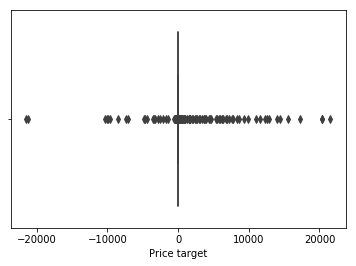

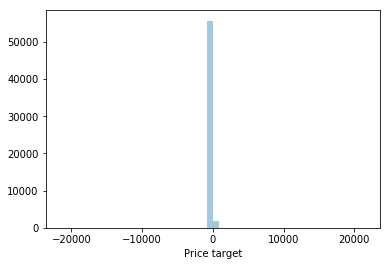

In [147]:
print(stocks['Price target'].describe())
sns.boxplot(stocks['Price target'])
plt.show()
sns.distplot(stocks['Price target'].dropna(),kde=False)

As expected our range for price change is huge and extremely spreadout. We could normalize this column, but would just be better to use percentage increase

## Distribution of the Price Percentage Change Column

count    57479.000000
mean         0.038931
std          0.713522
min         -0.990512
25%         -0.046578
50%          0.030821
75%          0.104272
max        118.988506
Name: Pricep target, dtype: float64


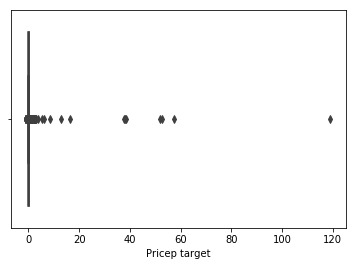

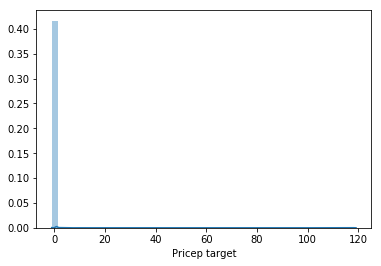

In [148]:
print(stocks['Pricep target'].describe())
sns.boxplot(stocks['Pricep target'])
plt.show()
sns.distplot(stocks['Pricep target'].dropna())

Looks like we have a few outliers that are really skewing our price percentage change columns

### Exploring Outliers

Looking for any price increase over 200% in a single quarter.

In [184]:
stocks.loc[list(stocks[stocks['Pricep target'] > 2].index -1)+ \
           list(stocks[stocks['Pricep target'] > 2].index)+ \
           list(stocks[stocks['Pricep target'] > 2].index + 1)] \
      .sort_values(['symbol', 'Year', 'Month']) \
      [['symbol', 'Year', 'Month', 'Price', 'Price target','Pricep target']]

,symbol,Year,Month,Price,Price target,Pricep target


| BTU 2017 | CIT 2009 | MAA 2017|
| --- | --- | --- |
| ![NN](./img/BTU2017.png) | ![NN](./img/CIT2009.png) | ![NN](./img/MAA2017.png)


Looks like we have a few data errors. In the month of June for BTU in 2017 never came close to reaching .53, same goes for CIT2009, and MAA in 2017. 

There isn't too many of these data errors so we'll just drop them before we run our in-depth analysis

### Without Outlier Price Percentage

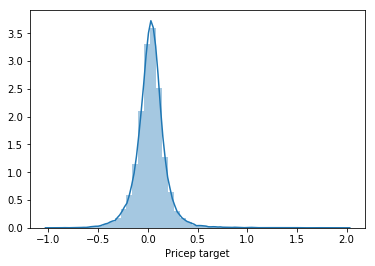

In [150]:
sns.distplot(stocks['Pricep target'].dropna().drop(stocks[stocks['Pricep target'] > 2].index))

Without the outliers our price percentage data looks remarkably normally distributed. This will work out nicely for our analysis and model

### Handling Error Data
Because I want to keep this analysis quick I will just fill the large outliers with NaN values. Then will perform a forward fill on the data. We will choose 2 for our cutoff value as this is a little greater than 2 standard deviations from the mean. Also, we explored these values above and found majority were errors.

In [151]:
stocks.loc[stocks[stocks['Pricep target'] > 2].index -1, 'Price'] = np.nan

In [181]:
stocks.loc[list(stocks[stocks['Pricep target'] > 2].index -1)+ \
           list(stocks[stocks['Pricep target'] > 2].index)+ \
           list(stocks[stocks['Pricep target'] > 2].index + 1)] \
            .sort_values(['symbol', 'Year', 'Month']) \
            ['Price'] = stocks.loc[list(stocks[stocks['Pricep target'] > 2].index -1)+ \
           list(stocks[stocks['Pricep target'] > 2].index)+ \
           list(stocks[stocks['Pricep target'] > 2].index + 1)] \
            .sort_values(['symbol', 'Year', 'Month']) \
            ['Price'].fillna(method='ffill')

In [182]:
#Regenerate our target columns after cleaning price data
pt = PriceTarget()
stocks = pt.fit_transform(stocks)

Column(s) Generated : ['Price_qchange']
Targets Created : ['Price target','Pricep target']


count    57434.000000
mean         0.030691
std          0.157099
min         -0.990512
25%         -0.046580
50%          0.030775
75%          0.104163
max          1.992486
Name: Pricep target, dtype: float64


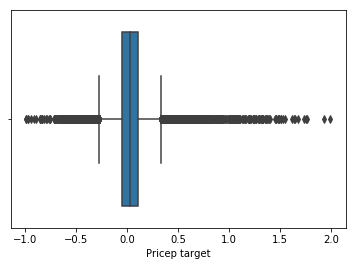

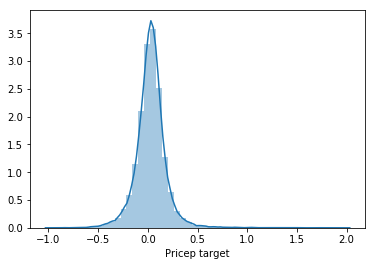

In [183]:
print(stocks['Pricep target'].describe())
sns.boxplot(stocks['Pricep target'])
plt.show()
sns.distplot(stocks['Pricep target'].dropna())

Without these errored rows our price percentage data looks remarkably normally distributed. This will work out nicely for our analysis and model.

# Preparing Features Needed for CAN SLIM analysis

## C - Current Quarterly Earnings
**C** stands for Current quarterly earnings. Per share, current earnings should be up at least 25% in the most recent financial quarter, compared to the same quarter the previous year. Additionally, if earnings are accelerating in recent quarters, this is a positive prognostic sign.

--Current Earnings Should be up at least 25% compared to same quarter the previous year

--Current Earnings should be up at least 20% compared to the previous quarter

--Current Earnings should be increasly accelerating

#### Generating Annual/Quarterly EPS Change Column

In [185]:
ac = AnnualChange(cols=['EPS basic'])
qc = QuarterlyChange(cols=['EPS basic'])
ag = AccelIncrease(cols=['EPS basic_qperc']) #Requires the Percent change column instead of base column
stocks = ac.fit_transform(stocks)
stocks = qc.fit_transform(stocks)
stocks = ag.fit_transform(stocks)

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Column(s) Generated : ['EPS basic_annual']
Column(s) Generated : ['EPS basic_qchange']
Columns Created : ['EPS basic_qperc_qacceleration', 'EPS basic_qperc_accstreak']


In [186]:
stocks.head(10)[['Year','Month','symbol','Price','EPS basic', 'EPS basic_qchange', 'EPS basic_qperc', 'EPS basic_annual','EPS basic_annualp','Price target', 'Pricep target', 'EPS basic_qperc_qacceleration', 'EPS basic_qperc_accstreak']]

,Year,Month,symbol,Price,EPS basic,EPS basic_qchange,EPS basic_qperc,EPS basic_annual,EPS basic_annualp,Price target,Pricep target,EPS basic_qperc_qacceleration,EPS basic_qperc_accstreak
72,2000,1,A,59.63,0.30,NaN,NaN,NaN,NaN,55.37,0.928559,NaN,NaN
71,2000,4,A,115.00,0.37,0.07,0.233333,NaN,NaN,-44.25,-0.384783,NaN,0.0
70,2000,7,A,70.75,0.34,-0.03,-0.081081,NaN,NaN,-19.84,-0.280424,-0.314414,0.0
69,2000,10,A,50.91,0.67,0.33,0.970588,NaN,NaN,2.12,0.041642,1.051669,1.0
68,2001,1,A,53.03,0.34,-0.33,-0.492537,0.04,0.133333,-13.03,-0.245710,-1.463126,0.0
67,2001,4,A,40.00,0.21,-0.13,-0.382353,-0.16,-0.432432,-6.31,-0.157750,0.110184,1.0
66,2001,7,A,33.69,-0.48,-0.69,-3.285714,-0.82,-2.411765,-8.34,-0.247551,-2.903361,0.0
65,2001,10,A,25.35,0.31,0.79,1.645833,-0.36,-0.537313,2.33,0.091913,4.931548,1.0
64,2002,1,A,27.68,-0.68,-0.99,-3.193548,-1.02,-3.000000,3.73,0.134754,-4.839382,0.0
63,2002,4,A,31.41,-0.55,0.13,0.191176,-0.76,-3.619048,-7.78,-0.247692,3.384725,1.0


### Current Earnings Should be up at least 25% compared to same quarter the previous year

Using the explore function created above I remove outliers which are outside a zcore of 2 to see the correlation of EPS Annual Increase with Price percent Increase.

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


Null Count:  0 ( 0.0 %)
count    50008.000000
mean         0.242250
std          1.938747
min        -17.000000
25%         -0.250000
50%          0.093709
75%          0.423729
max         17.600000
Name: EPS basic_annualp, dtype: float64


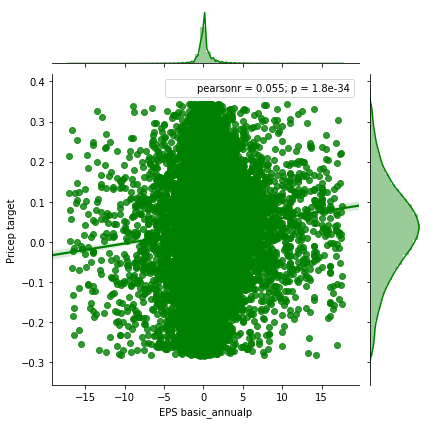

In [187]:
explore(stocks, 'EPS basic_annualp',youtliers=False,ythres=2,xoutliers=False,xthres=2)

Very weak correlation for EPS Annual Percent Increase with Stock Price Percent Increase. It has a mild positive relationship, but only a r of .055. A ton of factors go into whether a stock will increase or not so we would expect to see just one column scattered like this.  

#### Only Companies with Earnings up greater than 25%

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


Null Count:  0 ( 0.0 %)
count    17113.000000
mean         1.708149
std          2.790071
min          0.250000
25%          0.416667
50%          0.791667
75%          1.650000
max         25.095238
Name: EPS basic_annualp, dtype: float64


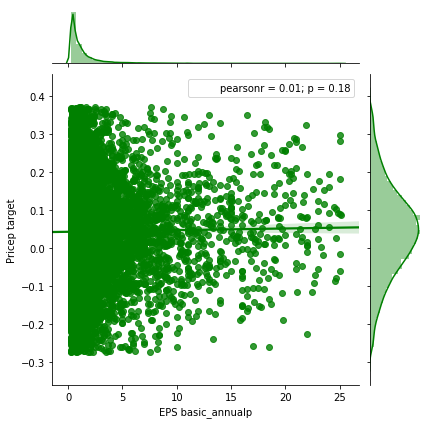

In [188]:
explore(stocks[stocks['EPS basic_annualp'] > .25], 'EPS basic_annualp', youtliers=False,ythres=2,xoutliers=False,xthres=2)

Doesn't appear to be any correlation even among companies that increase by at least 25% over the year.

### Current Earnings Should be up at least 20% compared to the previous quarter

Checking correlation of EPS Quarterly Increase ('EPS basic_qperc')  with Price percent Increase

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


Null Count:  0 ( 0.0 %)
count    52750.000000
mean         0.225440
std          2.796624
min        -37.500000
25%         -0.259211
50%          0.032609
75%          0.384615
max         37.500000
Name: EPS basic_qperc, dtype: float64


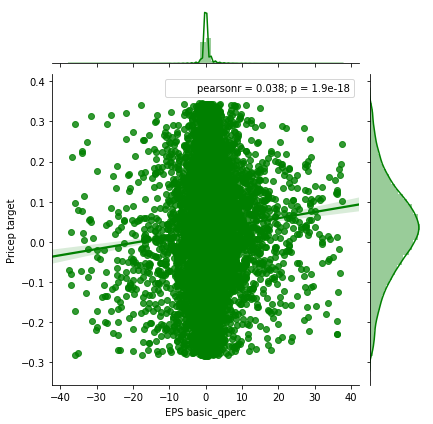

In [189]:
explore(stocks, 'EPS basic_qperc',youtliers=False,ythres=2,xoutliers=False,xthres=2)

Very weak correlation between the Price percentage increase and EPS increase for the quarter.

#### Only stocks up by over 20% from the previous years EPS

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


Null Count:  0 ( 0.0 %)
count    17708.000000
mean         1.589349
std          2.525048
min          0.200000
25%          0.378378
50%          0.739130
75%          1.571429
max         21.900000
Name: EPS basic_qperc, dtype: float64


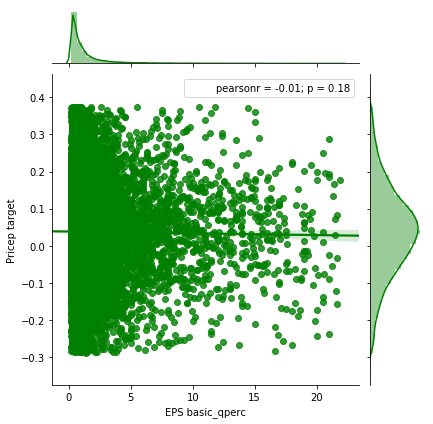

In [190]:
explore(stocks[stocks['EPS basic_qperc'] > .2], 'EPS basic_qperc',youtliers=False,ythres=2,xoutliers=False,xthres=2)

Unshockingly still no correlation for annual EPS increase

### EPS per quarter increases should be accelerating

'EPS basic_qperc_qacceleration', 'EPS basic_qperc_accstreak'

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


Null Count:  598 ( 1.1 %)
count    53997.000000
mean         0.634257
std          0.767298
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          6.000000
Name: EPS basic_qperc_accstreak, dtype: float64


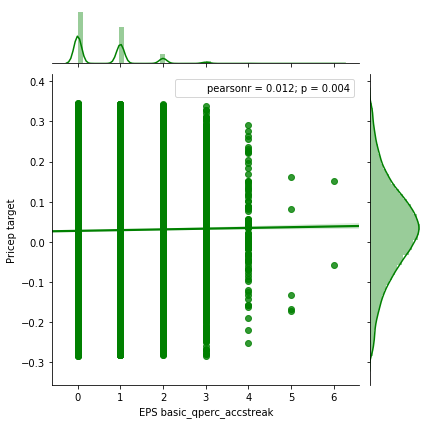

In [191]:
explore(stocks, 'EPS basic_qperc_accstreak',youtliers=False,ythres=2)

## A - Current Quarterly Earnings
**A** stands for Annual earnings growth, which should be up 25% or more over the last three years. Annual returns on equity should be 17% or more

--Annual Earnings Growth should be 25% or more over the last three years.

--Annual Return on Equity should be 17% or more

## Annual Earnings Growth should be 25% or more over the last three years

In [209]:
si = StreakIncrease(cols=['EPS basic_annualp'], x=.25)
stocks = si.fit_transform(stocks)

Columns Created : ['EPS basic_annualp_streakgt_0.25']


C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


Null Count:  0 ( 0.0 %)
count    5155.000000
mean        4.313676
std         1.650589
min         3.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        14.000000
Name: EPS basic_annualp_streakgt_0.25, dtype: float64


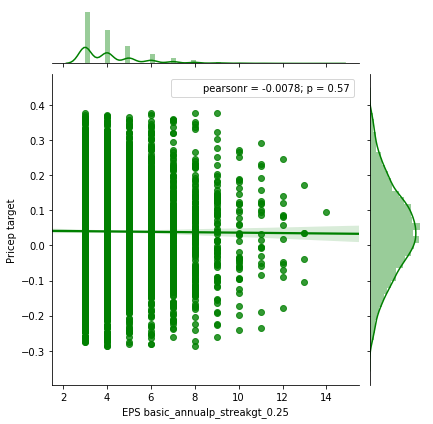

In [217]:
explore(stocks[stocks['EPS basic_annualp_streakgt_0.25'] >= 3], 'EPS basic_annualp_streakgt_0.25',youtliers=False,ythres=2)

No significant correlation between streaks of annual Earnings increases over 3 years. 

## Annual Return on Equity should be 17% or more
Our Return on Equity column is 'ROE'. Below I will check the correlation for ROE.

Null Count:  6268 ( 10.67 %)
count    52475.000000
mean         0.145851
std          0.181460
min         -0.997000
25%          0.080600
50%          0.145600
75%          0.219850
max          0.999200
Name: ROE, dtype: float64


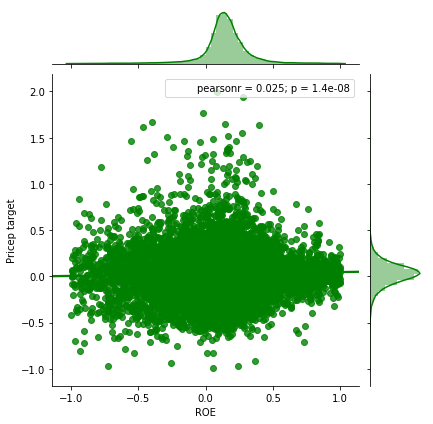

In [221]:
explore(stocks, 'ROE')

No significant correlation between ROE and stock price percent increase.